In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
pretrained_model = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet.decode_predictions

In [3]:
# Helper function to preprocess the image so that it can be inputted in Resnet50
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


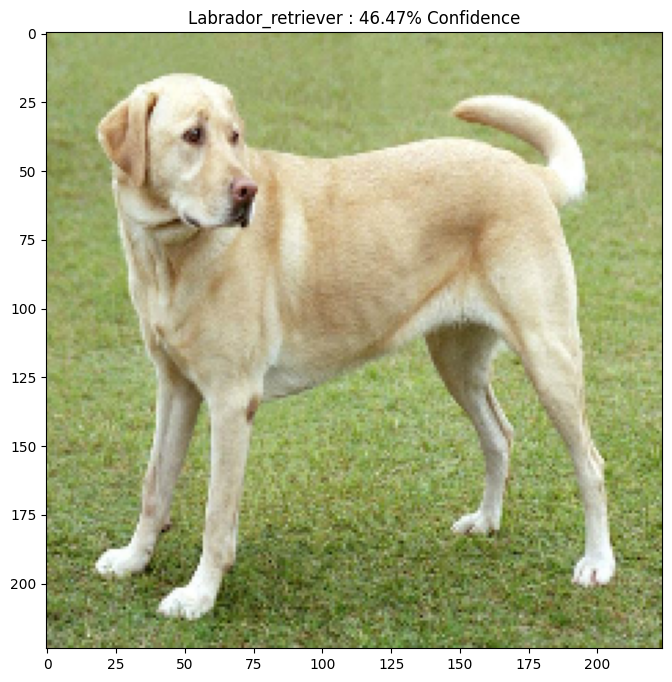

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# image_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Persian_cat.jpg'
# image_path = tf.keras.utils.get_file('Persian_cat.jpg', image_url)

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

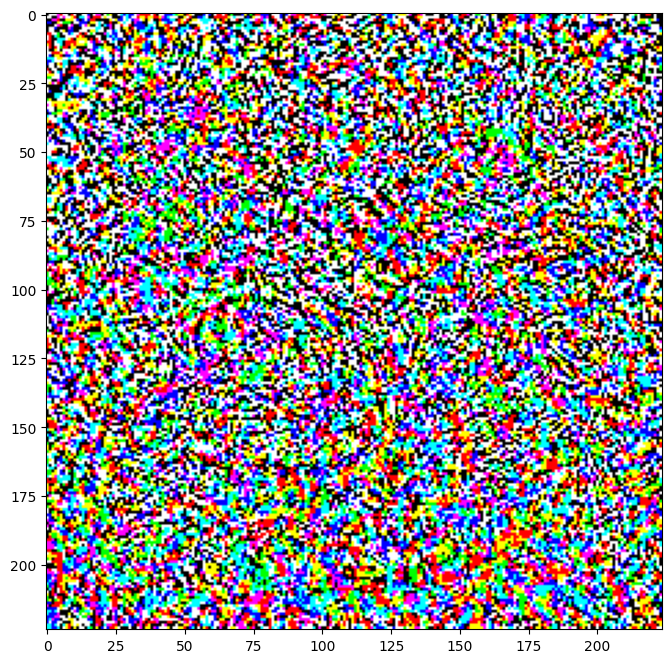

In [6]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [7]:
def display_images(images, descriptions, nrows=1, ncols=None):
    import math
    total = len(images)
    if ncols is None:
        ncols = math.ceil(total / nrows)

    plt.figure(figsize=(3 * ncols, 3 * nrows))

    for i, image in enumerate(images):
        _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image[0] * 0.5 + 0.5)
        plt.title(f'{descriptions[i]}\n{label}: {confidence * 100:.2f}%')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


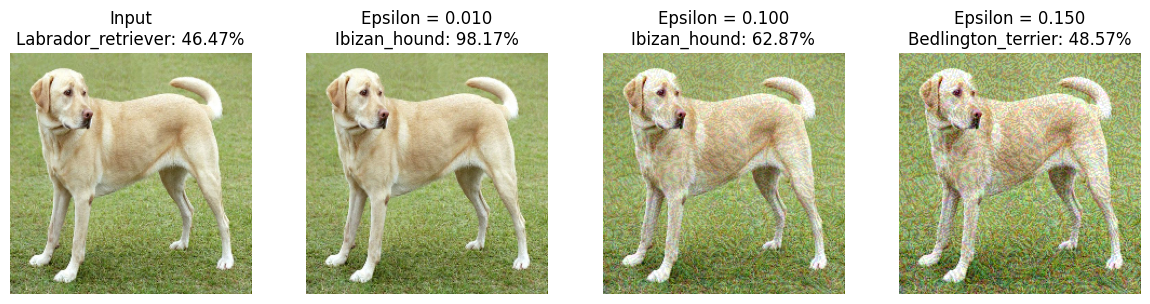

In [8]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
images = []

for eps in epsilons:
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    images.append(adv_x)

display_images(images, descriptions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


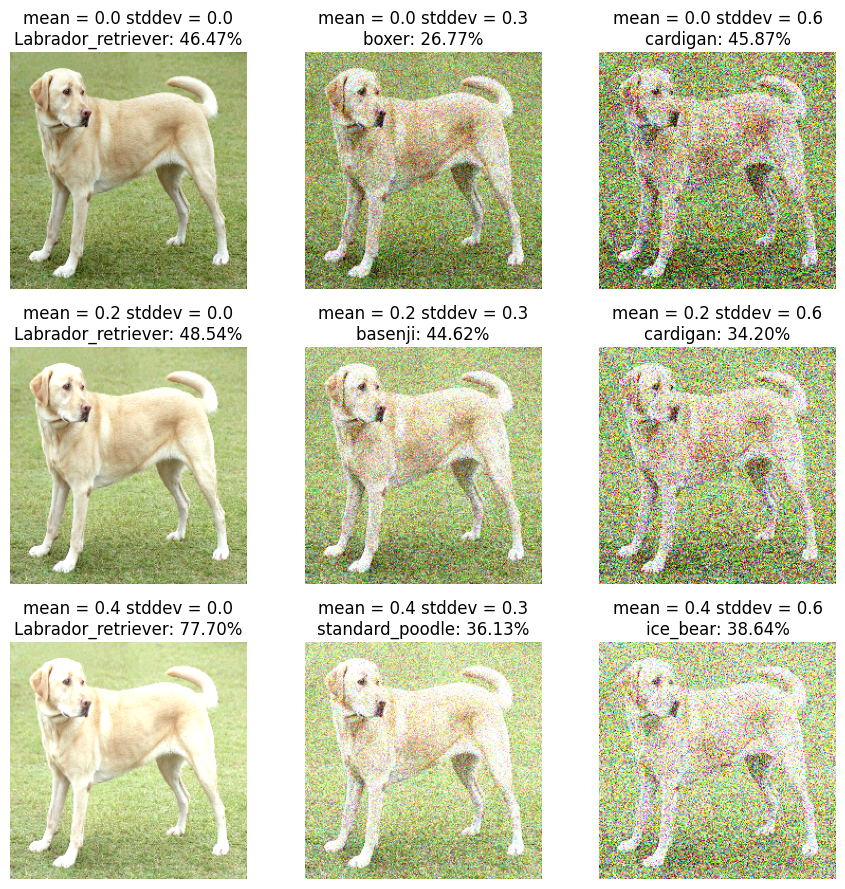

In [9]:
images_gauss = []
descriptions_gauss = []
for mean in [0.0, 0.2, 0.4]:
    for stddev in [0.0, 0.3, 0.6]:
        gaussian_noise = tf.random.normal(shape=image.shape, mean=mean, stddev=stddev)
        noisy_image = image + gaussian_noise
        noisy_image = tf.clip_by_value(noisy_image, -1, 1)
        images_gauss.append(noisy_image)
        descriptions_gauss.append(f'mean = {mean} stddev = {stddev}')
# print(descriptions_gauss)
display_images(images_gauss, descriptions_gauss, nrows=3)
